<a href="https://colab.research.google.com/github/anarlavrenov/ml_course_project_rest_api/blob/master/ml_in_business_course_project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# from google.colab import drive
# drive.mount('/content/drive')

import numpy as np
import pandas as pd
from matplotlib import pyplot as plt

from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import classification_report

# !pip install dill
import dill
import json
import urllib.request

In [4]:
def target_multibinary_conversion(x):
  if x == 'POLITICS':
    return 1
  elif x == 'WELLNESS':
    return 2
  elif x == 'ENTERTAINMENT':
    return 3
  elif x == 'TRAVEL':
    return 4
  elif x == 'STYLE & BEAUTY':
    return 5
  elif x == 'PARENTING':
    return 6
  elif x == 'FOOD & DRINK':
    return 7
  elif x == 'BUSINESS':
    return 8


def target_multibinary_inversion(x):
  if x == 1:
    return 'POLITICS'
  elif x == 2:
    return 'WELLNESS'
  elif x == 3:
    return 'ENTERTAINMENT'
  elif x == 4:
    return 'TRAVEL'
  elif x == 5:
    return 'STYLE & BEAUTY'
  elif x == 6:
    return 'PARENTING'
  elif x == 7:
    return 'FOOD & DRINK'
  elif x == 8:
    return 'BUSINESS'

In [5]:
PATH = "/content/drive/MyDrive/Colab Notebooks/машинное_обучение_в_бинесе/курсовой_проект/"

In [6]:
df = pd.read_json(PATH + "News_Category_Dataset_v3.json", lines=True)

In [7]:
# Оставляю только самые популярные категории 
top_categories = df.category.value_counts()[:10].drop(['HEALTHY LIVING']).index.tolist()
top_categories.remove('QUEER VOICES')

df['top_categories'] = 0
df.top_categories = df.category.apply(lambda x: 1 if x in top_categories else 0)

# Удаляю признаки link, authors
df = df[df['top_categories'] == 1].drop(columns=['top_categories', 'link', 'authors'])

# Переставляю местами колонки, чтобы было удобно воспринимать информацию
df = df[['date', 'headline', 'short_description', 'category']]

In [8]:
TARGET = 'category'

In [9]:
df.head(3)

,date,headline,short_description,category
3,2022-09-23,The Funniest Tweets From Parents This Week (Se...,"""Accidentally put grown-up toothpaste on my to...",PARENTING
20,2022-09-20,Golden Globes Returning To NBC In January Afte...,"For the past 18 months, Hollywood has effectiv...",ENTERTAINMENT
21,2022-09-19,Biden Says U.S. Forces Would Defend Taiwan If ...,President issues vow as tensions with China rise.,POLITICS


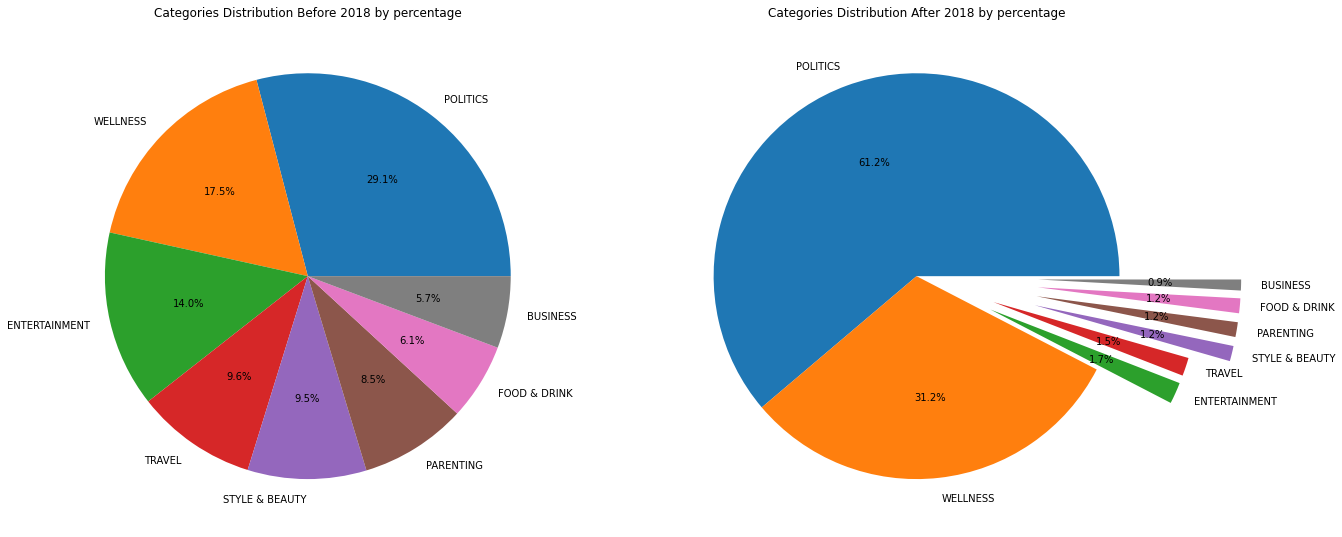

In [10]:
categories_names = df.category.value_counts().index.tolist()

categories_count_before_2018 = df[df['date'] < '2018-01-01']['category'].value_counts().values.tolist()
categories_perc_before_2018 = [x / sum(categories_count_before_2018) * 100 for x in categories_count_before_2018]

# Визуализирую процентное распределение категорий до и после 2018 года
categories_count_after_2018 = df[df['date'] > '2018-01-01']['category'].value_counts().values.tolist()
categories_perc_after_2018 = [x / sum(categories_count_after_2018) * 100 for x in categories_count_after_2018]

fig, ax = plt.subplots(1, 2, figsize=(20, 12))

explode = (0, 0, 0.4, 0.4, 0.6, 0.6, 0.6, 0.6)

ax[0].pie(categories_perc_before_2018, labels=categories_names, autopct='%1.1f%%')
ax[0].set_title('Categories Distribution Before 2018 by percentage')

ax[1].pie(categories_perc_after_2018, labels=categories_names, explode=explode, autopct='%1.1f%%')
ax[1].set_title('Categories Distribution After 2018 by percentage')
plt.show()

In [11]:
X = df.drop(columns=[TARGET, 'date'])
y = df[TARGET]
y = y.apply(target_multibinary_conversion)

X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.33, 
                                                      shuffle=True, random_state=42)

# Создаю копию y_valid, чтобы потом сверить обратную конвертацию мультибинарного класса с численными значениями - в словесные  
y_valid_ = y_valid.copy()

In [12]:
class FeatureSelection(BaseEstimator, TransformerMixin):
  def __init__(self, column):
    self.column = column

  def fit(self, X, y=None):
    return self
  
  def transform(self, X, y=None):
    return X[self.column]


headline = Pipeline([('column', FeatureSelection(column='headline')),
                    ('tfidf', TfidfVectorizer())])

descr = Pipeline([('column', FeatureSelection(column='short_description')),
                    ('tfidf', TfidfVectorizer())])

feats = FeatureUnion([('headline', headline),
                      ('descr', descr)])

pipeline = Pipeline([('feats', feats),
                     ('clf', LogisticRegression(random_state=42))])

In [13]:
pipeline.fit(X_train, y_train)

/usr/local/lib/python3.8/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Pipeline(steps=[('feats',
                 FeatureUnion(transformer_list=[('headline',
                                                 Pipeline(steps=[('column',
                                                                  FeatureSelection(column='headline')),
                                                                 ('tfidf',
                                                                  TfidfVectorizer())])),
                                                ('descr',
                                                 Pipeline(steps=[('column',
                                                                  FeatureSelection(column='short_description')),
                                                                 ('tfidf',
                                                                  TfidfVectorizer())]))])),
                ('clf', LogisticRegression(random_state=42))])

In [14]:
y_valid_pred = pipeline.predict(X_valid)

In [15]:
print(classification_report(y_valid, y_valid_pred))

              precision    recall  f1-score   support

           1       0.89      0.94      0.91     11735
           2       0.79      0.88      0.83      5836
           3       0.84      0.87      0.86      5793
           4       0.86      0.82      0.84      3276
           5       0.92      0.84      0.88      3267
           6       0.82      0.75      0.78      2926
           7       0.86      0.79      0.82      2057
           8       0.75      0.51      0.60      1987

    accuracy                           0.85     36877
   macro avg       0.84      0.80      0.82     36877
weighted avg       0.85      0.85      0.85     36877



In [16]:
y_valid_ = y_valid_.apply(target_multibinary_inversion)
y_valid_pred_ = pd.Series(y_valid_pred).apply(target_multibinary_inversion)

In [17]:
print(classification_report(y_valid_, y_valid_pred_))

                precision    recall  f1-score   support

      BUSINESS       0.75      0.51      0.60      1987
 ENTERTAINMENT       0.84      0.87      0.86      5793
  FOOD & DRINK       0.86      0.79      0.82      2057
     PARENTING       0.82      0.75      0.78      2926
      POLITICS       0.89      0.94      0.91     11735
STYLE & BEAUTY       0.92      0.84      0.88      3267
        TRAVEL       0.86      0.82      0.84      3276
      WELLNESS       0.79      0.88      0.83      5836

      accuracy                           0.85     36877
     macro avg       0.84      0.80      0.82     36877
  weighted avg       0.85      0.85      0.85     36877



In [18]:
# with open(PATH + "logreg_pipeline.dill", 'wb') as f:
#   dill.dump(pipeline, f)

REST API

In [26]:
def get_prediction(x):
  headline, short_description = x

  body = dict(headline = headline, short_description = short_description)

  url = "http://127.0.0.1:8380/predict"
  req = urllib.request.Request(url)
  req.add_header('Content-Type', 'application/json; charset=utf-8')

  j_data = json.dumps(body)
  j_data_bytes = j_data.encode('utf-8')
  req.add_header('Content-Length', len(j_data_bytes))

  response = urllib.request.urlopen(req, j_data_bytes)

  result = json.loads(response.read())

  return result